<a href="https://colab.research.google.com/github/FrancescaForbicini/Artificial-Neural-Network-and-Deep-Learning/blob/main/Second%20Challenge/Final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup environment

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:
PATH = '/gdrive/My Drive/YOUR_PATH'
%cd PATH

### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import warnings
import logging
import sklearn.utils as sku
from sklearn.model_selection import train_test_split
import imblearn.under_sampling as imbunder
import imblearn.over_sampling as imbover
import imblearn.combine as combine

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Suppressed Warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Global variables

In [ ]:
dataset_dir = 'dataset'
save_dir = 'models'

validation_split = .1
batch_size = 32
epochs = 1000
seed = 42
shrinking_factor = 0.2

### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Prepare dataset

### Load dataset

In [ ]:
x = np.load(f'{dataset_dir}/x_train.npy')
num_samples = len(x)
window = len(x[0])
dims = len(x[0][0])
y = np.load('dataset/y_train.npy')
classes = y.max()-y.min()+1

In [ ]:
def get_samples_per_class(labels, verbose=True):
  samples_per_class = np.zeros(classes).astype(int)
  for i in range(0,len(labels)):
    samples_per_class[labels[i].astype(int)] += 1
  if verbose:
    print(samples_per_class)
  return samples_per_class

### Undersampling

In [ ]:
x = np.reshape(x, (num_samples,window*dims))

samples_per_class = get_samples_per_class(y)

avg_samples = np.floor(samples_per_class.sum()/classes).astype(int)

sampling_strategy = {}
for i in range(classes):
  under = np.ceil(((avg_samples-samples_per_class[i])*shrinking_factor+samples_per_class[i])).astype(int)
  if(samples_per_class[i] > under):
    sampling_strategy[i] = under
  else:
    sampling_strategy[i] = samples_per_class[i]

undersampler = imbunder.RandomUnderSampler(sampling_strategy=sampling_strategy)
x, y = undersampler.fit_resample(x, y)

samples_per_class = get_samples_per_class(y)

num_samples = len(x)
x = np.reshape(x, (num_samples, window, dims))

[ 34 123 270 381  62 153 313  68 120 777  77  51]
[ 34 123 257 346  62 153 291  68 120 662  77  51]


### Split test and validation

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=validation_split, random_state=seed, stratify=y)

x_train, y_train = sku.shuffle(x_train,y_train,random_state = seed)

train_samples = len(x_train)
get_samples_per_class(y_train)
test_samples = len(x_test)
get_samples_per_class(y_test)

[ 30 111 231 311  56 138 262  61 108 596  69  46]
[ 4 12 26 35  6 15 29  7 12 66  8  5]


array([ 4, 12, 26, 35,  6, 15, 29,  7, 12, 66,  8,  5])

### Oversampling

In [ ]:
x_train = np.reshape(x_train, (train_samples,window*dims))

sampling_strategy = {}
for i in range(classes):
  over = np.ceil(((avg_samples-samples_per_class[i])*shrinking_factor+samples_per_class[i])).astype(int)
  if samples_per_class[i] < over:
    sampling_strategy[i] = over
  else:
    sampling_strategy[i] = samples_per_class[i]

oversampler = imbover.RandomOverSampler(sampling_strategy=sampling_strategy)
x_train, y_train = oversampler.fit_resample(x_train, y_train)


train_samples = len(x_train)
get_samples_per_class(y_train)
x_train = np.reshape(x_train, (train_samples, window, dims))

[ 68 139 257 346  90 163 291  95 137 662 102  82]


### Go to categorical labels

In [ ]:
#Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)

### Normalize

In [ ]:
# Apply RobustScaler to the useful features
x_train = np.reshape(x_train, (train_samples, window*dims))
x_test = np.reshape(x_test, (test_samples, window*dims))

scaler = RobustScaler()
scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

x_train = np.reshape(x_train, (train_samples, window, dims))
x_test = np.reshape(x_test, (test_samples, window, dims))

# Build and train model

In [ ]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]

#### Build model

In [ ]:
def build_classifier(input_shape, classes):
  # Build the neural network layer by layer
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  x = tfkl.GaussianNoise(.1)(input_layer)

  # Feature extractor
  x = tfkl.Conv1D(filters=128, kernel_size=6,padding='same',activation='relu')(x)
  x = tfkl.Dropout(.4, seed=seed)(x)
  x = tfkl.Conv1D(filters=64, kernel_size=3,padding='same',activation='relu')(x)
  x = tfkl.Dropout(.4, seed=seed)(x)

  y = tfkl.Conv1D(filters=64, kernel_size=1, padding='same',activation='relu')(input_layer)
  y = tfkl.Dropout(.4, seed=seed)(y)


  x = tfkl.add([y, x])
  x = tfkl.Activation('relu')(x)

  x = tfkl.GlobalAveragePooling1D()(x)


  # Classifier
  x = tfkl.Dense(128, activation='relu')(x)
  x = tfkl.Dropout(.4, seed=seed)(x)
  output_layer = tfkl.Dense(classes, activation='softmax')(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

  # Return the model
  return model

In [ ]:
model = build_classifier(input_shape, classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 36, 6)       0           ['Input[0][0]']                  
                                                                                                  
 conv1d (Conv1D)                (None, 36, 128)      4736        ['gaussian_noise[0][0]']         
                                                                                                  
 dropout (Dropout)              (None, 36, 128)      0           ['conv1d[0][0]']                 
                                                                                              

In [ ]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=30 , min_lr=1e-10)
    ]
  ).history

Epoch 1/1000
76/76 [==============================] - 10s 7ms/step - loss: 5.0818 - accuracy: 0.1883 - val_loss: 2.4038 - val_accuracy: 0.2978 - lr: 0.0010
Epoch 2/1000
76/76 [==============================] - 0s 5ms/step - loss: 3.0943 - accuracy: 0.3100 - val_loss: 2.1629 - val_accuracy: 0.3511 - lr: 0.0010
Epoch 3/1000
76/76 [==============================] - 0s 4ms/step - loss: 2.5547 - accuracy: 0.3516 - val_loss: 2.0644 - val_accuracy: 0.3911 - lr: 0.0010
Epoch 4/1000
76/76 [==============================] - 0s 4ms/step - loss: 2.2804 - accuracy: 0.3532 - val_loss: 1.8825 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 5/1000
76/76 [==============================] - 0s 4ms/step - loss: 2.1302 - accuracy: 0.3775 - val_loss: 1.7743 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/1000
76/76 [==============================] - 0s 4ms/step - loss: 2.0032 - accuracy: 0.3840 - val_loss: 1.7095 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 7/1000
76/76 [==============================] - 0s 4ms/step - l

### Plot results

In [ ]:
from datetime import datetime
dir = f'{save_dir}/date{datetime.now()}acc{max(history["val_accuracy"])}'
os.mkdir(dir)

In [ ]:
predictions = model.predict(x_test)
predictions.shape

8/8 [==============================] - 0s 2ms/step


(225, 12)

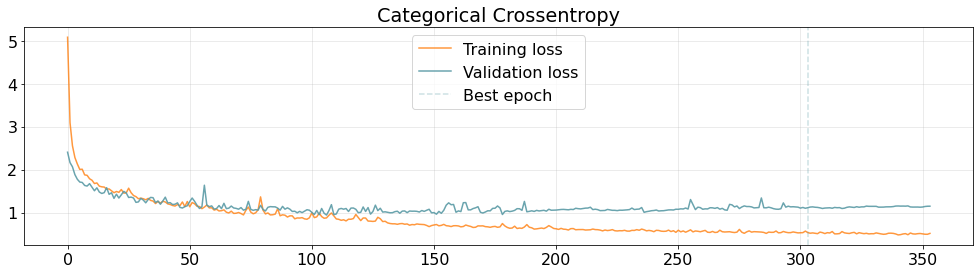

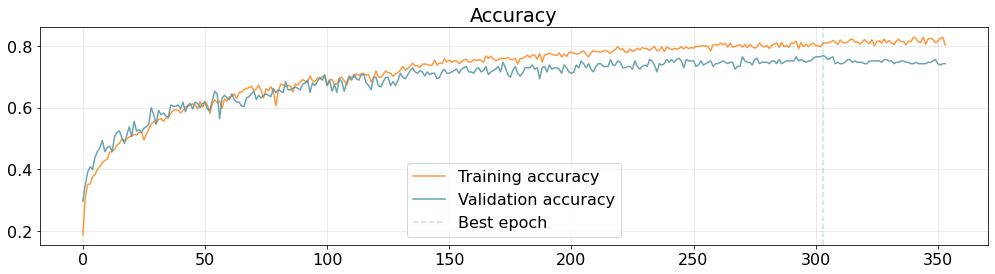

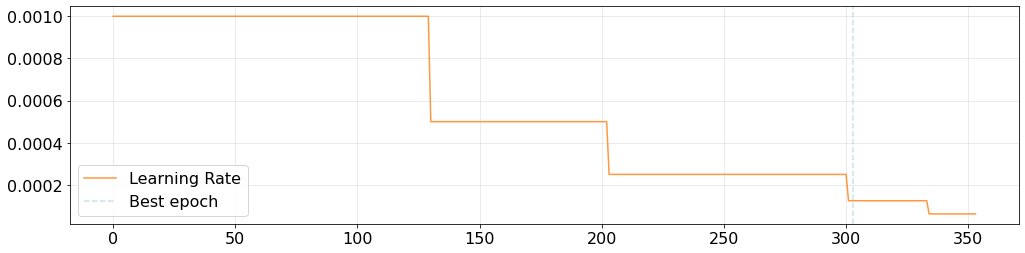

Accuracy: 0.7689
Precision: 0.7005
Recall: 0.6279
F1: 0.6469


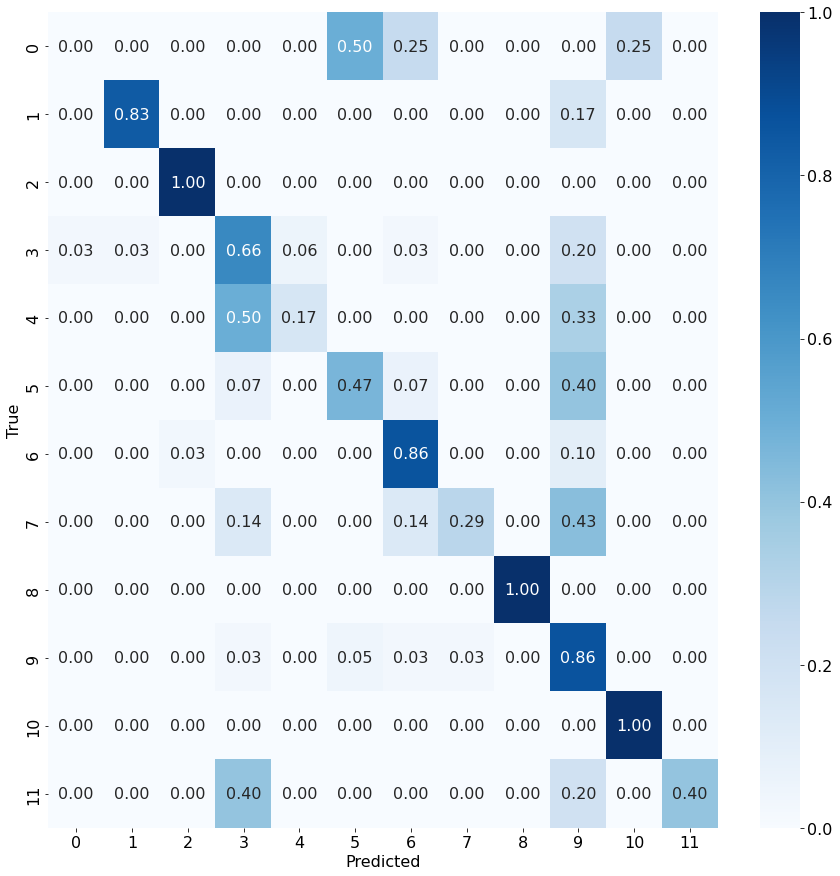

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn,  cmap='Blues', annot=True, fmt='.2f',xticklabels=range(12), yticklabels=range(12))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show(block=False)
fig.savefig(f'{dir}/confusion_matrix.png')

In [ ]:
print(max(history['val_accuracy']))

0.7688888907432556


### Save model

In [ ]:
model.save(dir)

In [ ]:
from pickle import dump

dump(scaler, open(f'{dir}/scaler.pkl', 'wb'))

In [ ]:
%cp "/gdrive/My Drive/Colab Notebooks/Final model.ipynb" "/gdrive/My Drive/My ANNDL/Challenge2/$dir"
%cd "/gdrive/My Drive/My ANNDL/Challenge2/$dir"
%ls

cp: cannot stat '/gdrive/My Drive/Colab Notebooks/Final model.ipynb': No such file or directory
/gdrive/My Drive/My ANNDL/Challenge2/models/date2022-12-22 17:40:58.591364acc0.7688888907432556
assets/               keras_metadata.pb  scaler.pkl
confusion_matrix.png  saved_model.pb     variables/
